# Description

- Initialize with returns, predictions, target volatility, and oos start date
- Evaluate portfolios generated from the predictions

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import pandas as pd

import core.artificial_signal_generators as sig_gen
import core.config as cconfig
import core.dataflow_model.model_evaluator as modeval
import core.dataflow_model.model_plotter as modplot
import core.dataflow_model.utils as cdmu
import core.statistics as stats
import helpers.dbg as dbg
import helpers.env as env
import helpers.printing as prnt

In [2]:
dbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

# _LOG.info("%s", env.get_system_signature()[0])

# prnt.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-ad2b4cab-bc05-4fc4-afa9-cadc4b7438db.json'


# Notebook config

In [3]:
eval_config = cconfig.get_config_from_nested_dict(
    {
        "exp_dir": "/app/experiment1",
        "model_evaluator_kwargs": {
            "returns_col": "ret_0_vol_adj_2",
            "predictions_col": "ret_0_vol_adj_2_hat",
            "target_volatility": 0.1,
            "oos_start": "2017-01-01",
        },
        "bh_adj_threshold": 0.1,
        "resample_rule": "W",
        "mode": "ins",
        "target_volatility": 0.1,
    }
)

# Generate mock returns and predictions

- This is a placeholder
- In practice, the user should supply `rets` and `preds`

In [4]:
# Generate synthetic returns.
mn_process = sig_gen.MultivariateNormalProcess()
mn_process.set_cov_from_inv_wishart_draw(dim=32, seed=0)
realization = mn_process.generate_sample(
    {"start": "2000-01-01", "end": "2010-01-01", "freq": "B"}, seed=0
)
rets = realization.to_dict(orient="series")

In [5]:
# Generate fake predictions.
noise = sig_gen.MultivariateNormalProcess(
    pd.Series(data=[0] * 32), pd.DataFrame(np.identity(32))
)
noise_draw = noise.generate_sample(
    {"start": "2000-01-01", "end": "2010-01-01", "freq": "B"}, seed=0
)
pred_df = 0.01 * realization + 0.1 * noise_draw
# Adjust so that all models have positive SR.
pred_df = (
    stats.compute_annualized_sharpe_ratio(pred_df.multiply(realization))
    .apply(np.sign)
    .multiply(pred_df)
)

In [6]:
preds = pred_df.to_dict(orient="series")

# Initialize ModelEvaluator and ModelPlotter

In [7]:
if eval_config.get("exp_dir", None) is None:
    evaluator = modeval.ModelEvaluator(
        returns=rets,
        predictions=preds,
        target_volatility=eval_config["model_evaluator_kwargs", "target_volatility"],
        oos_start=eval_config["model_evaluator_kwargs", "oos_start"],
    )
else:
    rbs_dicts = cdmu.load_experiment_artifacts(
        eval_config["exp_dir"],
        "result_bundle.pkl"
    )
    evaluator = modeval.build_model_evaluator_from_result_bundle_dicts(
        rbs_dicts,
        **eval_config["model_evaluator_kwargs"].to_dict(),
    )

plotter = modplot.ModelPlotter(evaluator)

# Load artifacts 'result_bundle.pkl' from '/app/experiment1'
Found 2 experiment subdirs in '/app/experiment1'
Loading '/app/experiment1/result_0/result_bundle.pkl'
Loading '/app/experiment1/result_1/result_bundle.pkl'


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

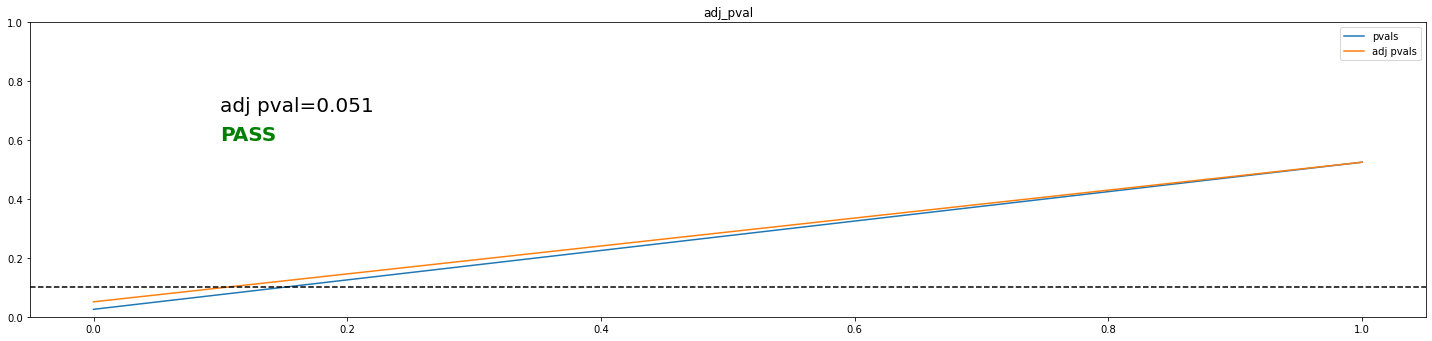

In [8]:
plotter.plot_multiple_tests_adjustment(
    threshold=eval_config["bh_adj_threshold"], mode=eval_config["mode"]
)

In [9]:
pnl_stats = evaluator.calculate_stats(mode=eval_config["mode"])
pnl_stats

  0%|          | 0/2 [00:00<?, ?it/s]

,0,1
sharpe_ratio,1.579745,0.449647
sharpe_ratio_standard_error,0.706843,0.706847
tval,2.236668,0.636065
pval,0.025394,0.524792
kratio,0.498289,0.340734
annualized_mean_return_(%),15.797449,4.496474
annualized_volatility_(%),10.0,10.0
max_drawdown_(%),-8.0684,-8.147168
start_time,2016-06-30 10:45:00,2016-06-30 14:00:00
end_time,2016-12-30 15:30:00,2016-12-30 15:30:00


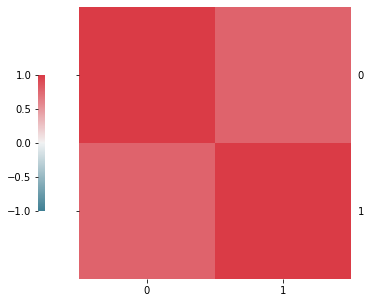

In [10]:
plotter.plot_correlation_matrix(
    series="pnls",
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)

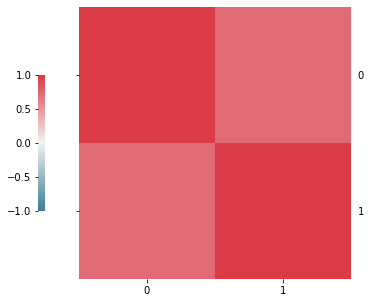

In [11]:
plotter.plot_correlation_matrix(
    series="returns",
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)

In [12]:
col_mask = pnl_stats.loc["adj_pval"] < eval_config["bh_adj_threshold"]
selected = pnl_stats.loc[:, col_mask].columns.to_list()

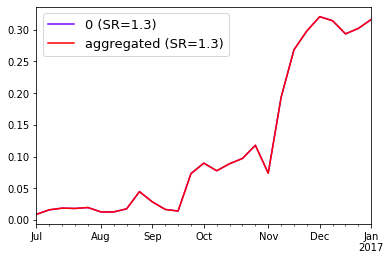

In [13]:
plotter.plot_multiple_pnls(
    keys=selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)

In [14]:
evaluator.aggregate_models(
    keys=selected,
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)[2].to_frame()

,stats
sharpe_ratio,1.579745
sharpe_ratio_standard_error,0.706843
tval,2.236668
pval,0.025394
kratio,0.498289
annualized_mean_return_(%),15.797449
annualized_volatility_(%),10.0
max_drawdown_(%),-8.0684
start_time,2016-06-30 10:45:00
end_time,2016-12-30 15:30:00


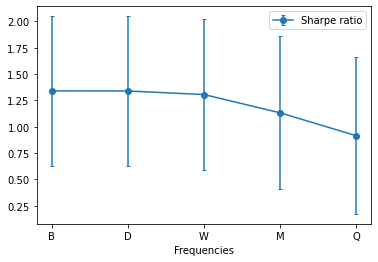

In [15]:
plotter.plot_sharpe_ratio_panel(keys=selected, mode=eval_config["mode"])

/venv/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 105, using nperseg = 105
  warnings.warn('nperseg = {0:d} is greater than input length '
/venv/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 105, using nperseg = 105
  warnings.warn('nperseg = {0:d} is greater than input length '
/app/amp/core/plotting.py:735: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax2.pcolormesh(t, f_sxx, Sxx)


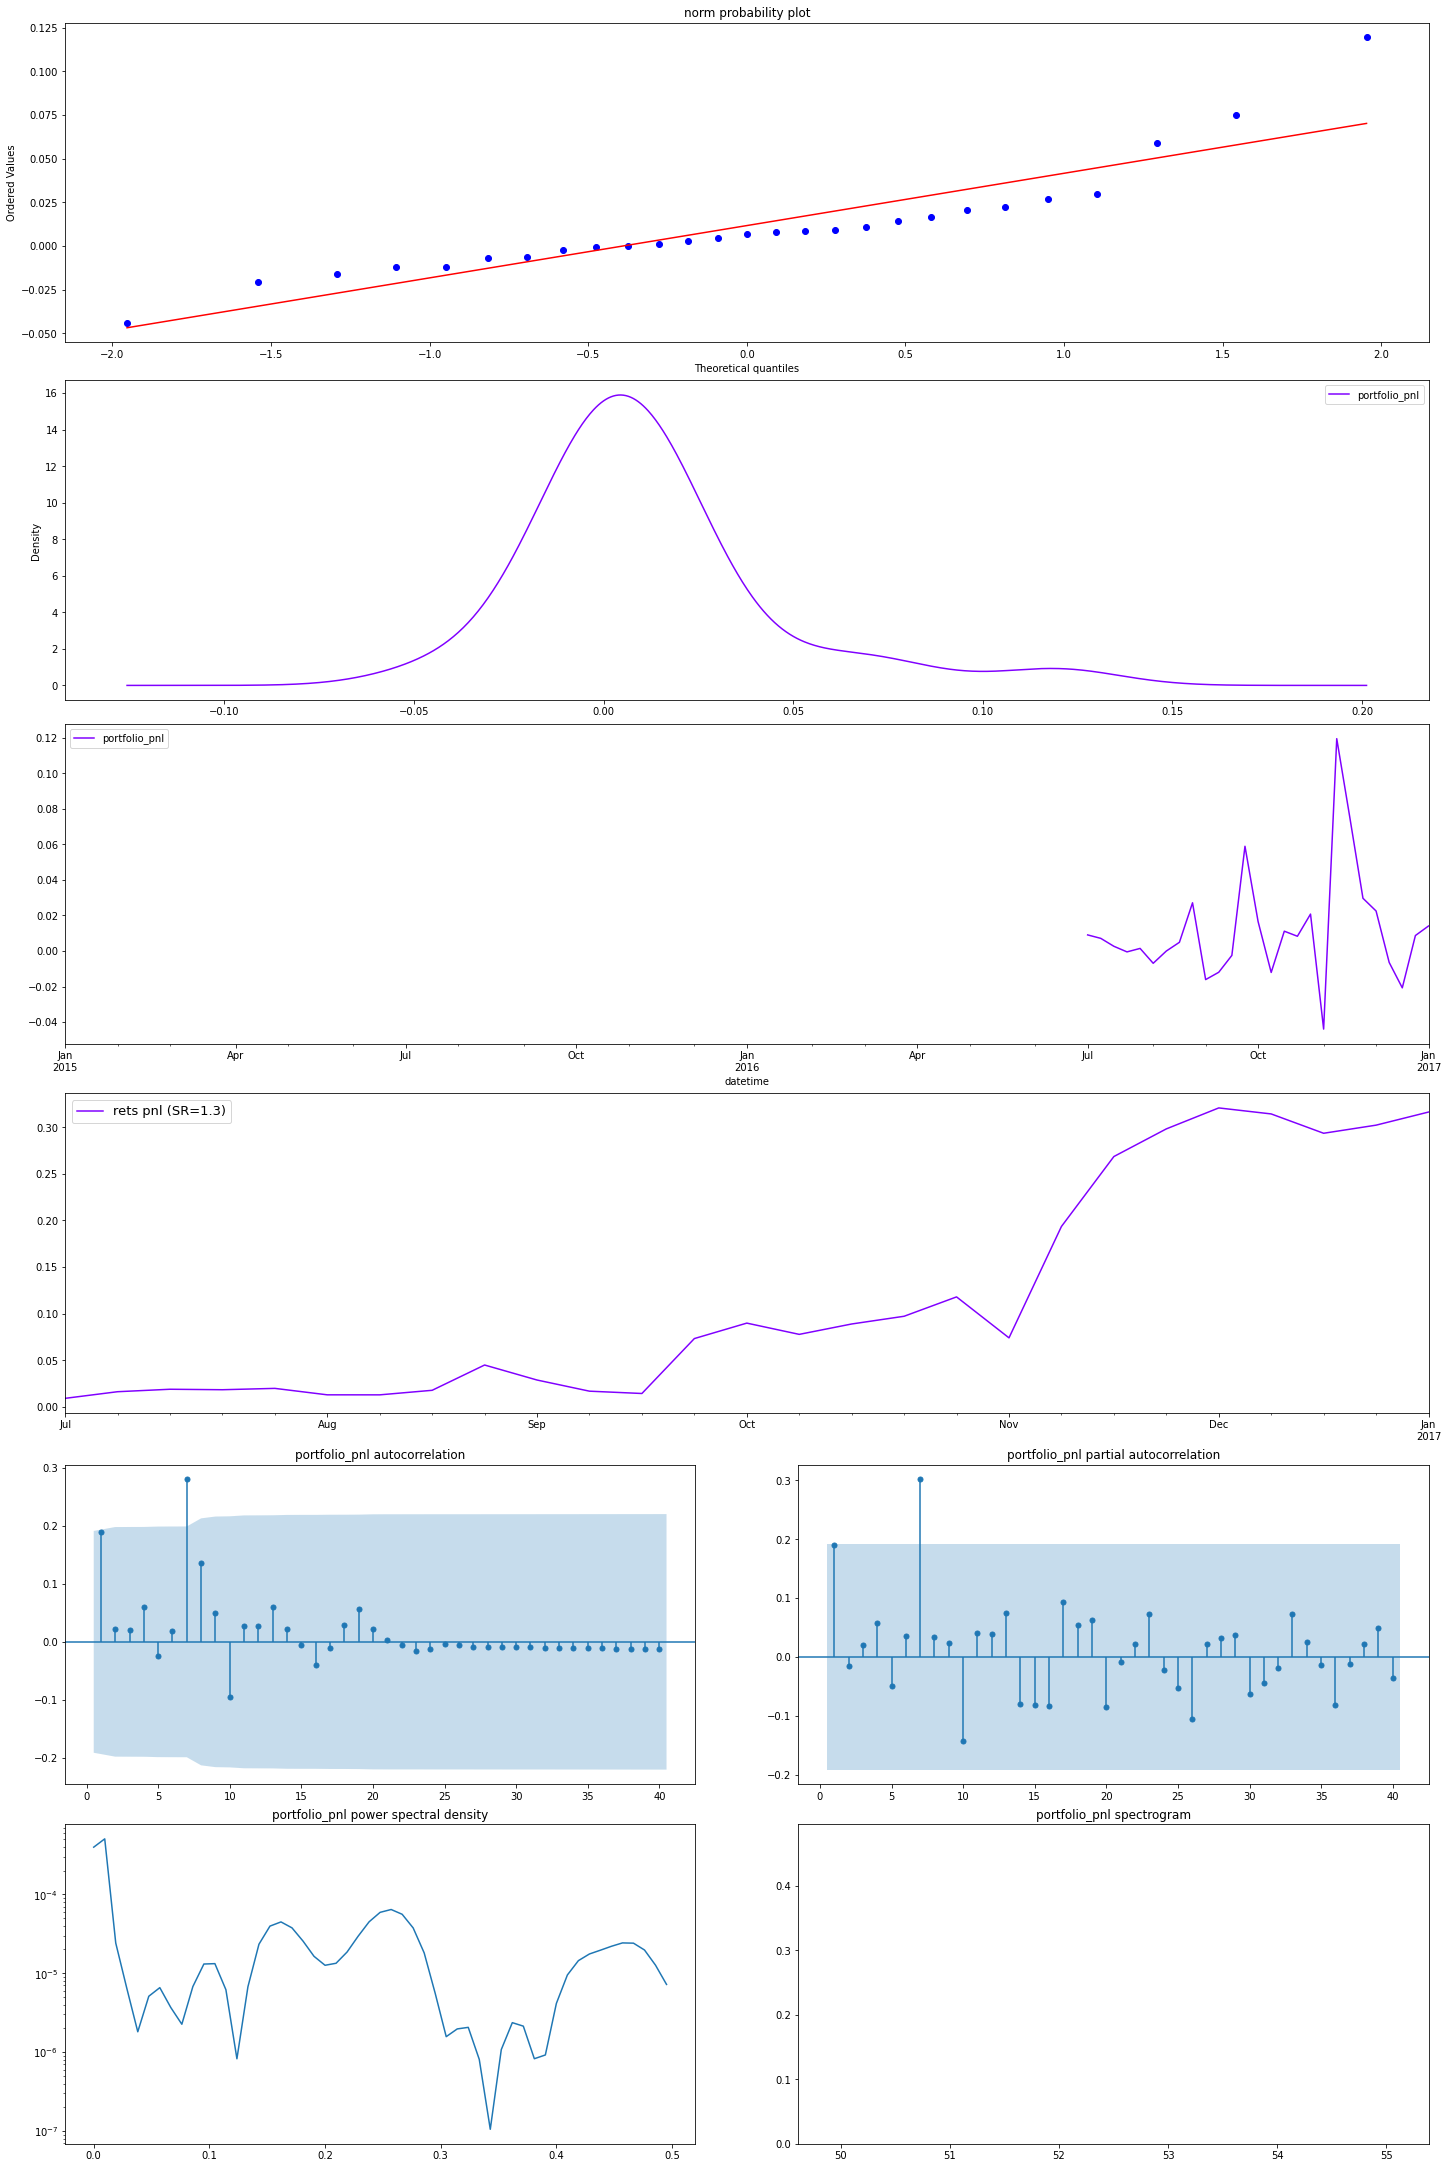

In [16]:
plotter.plot_rets_signal_analysis(
    keys=selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

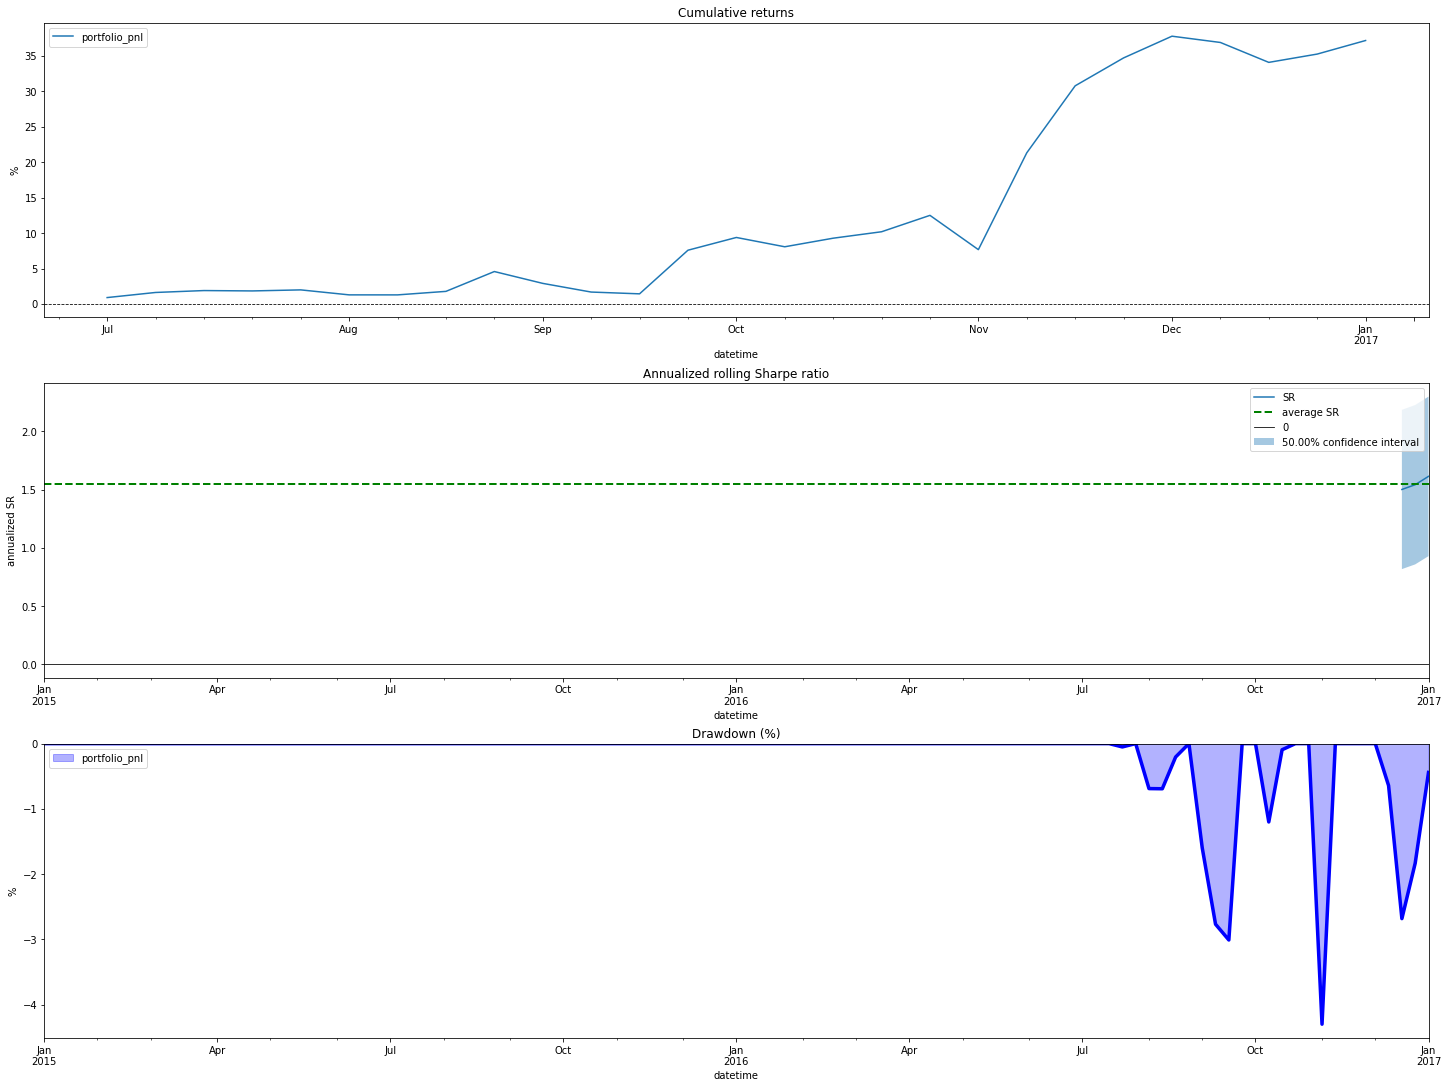

In [17]:
plotter.plot_performance(
    keys=selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

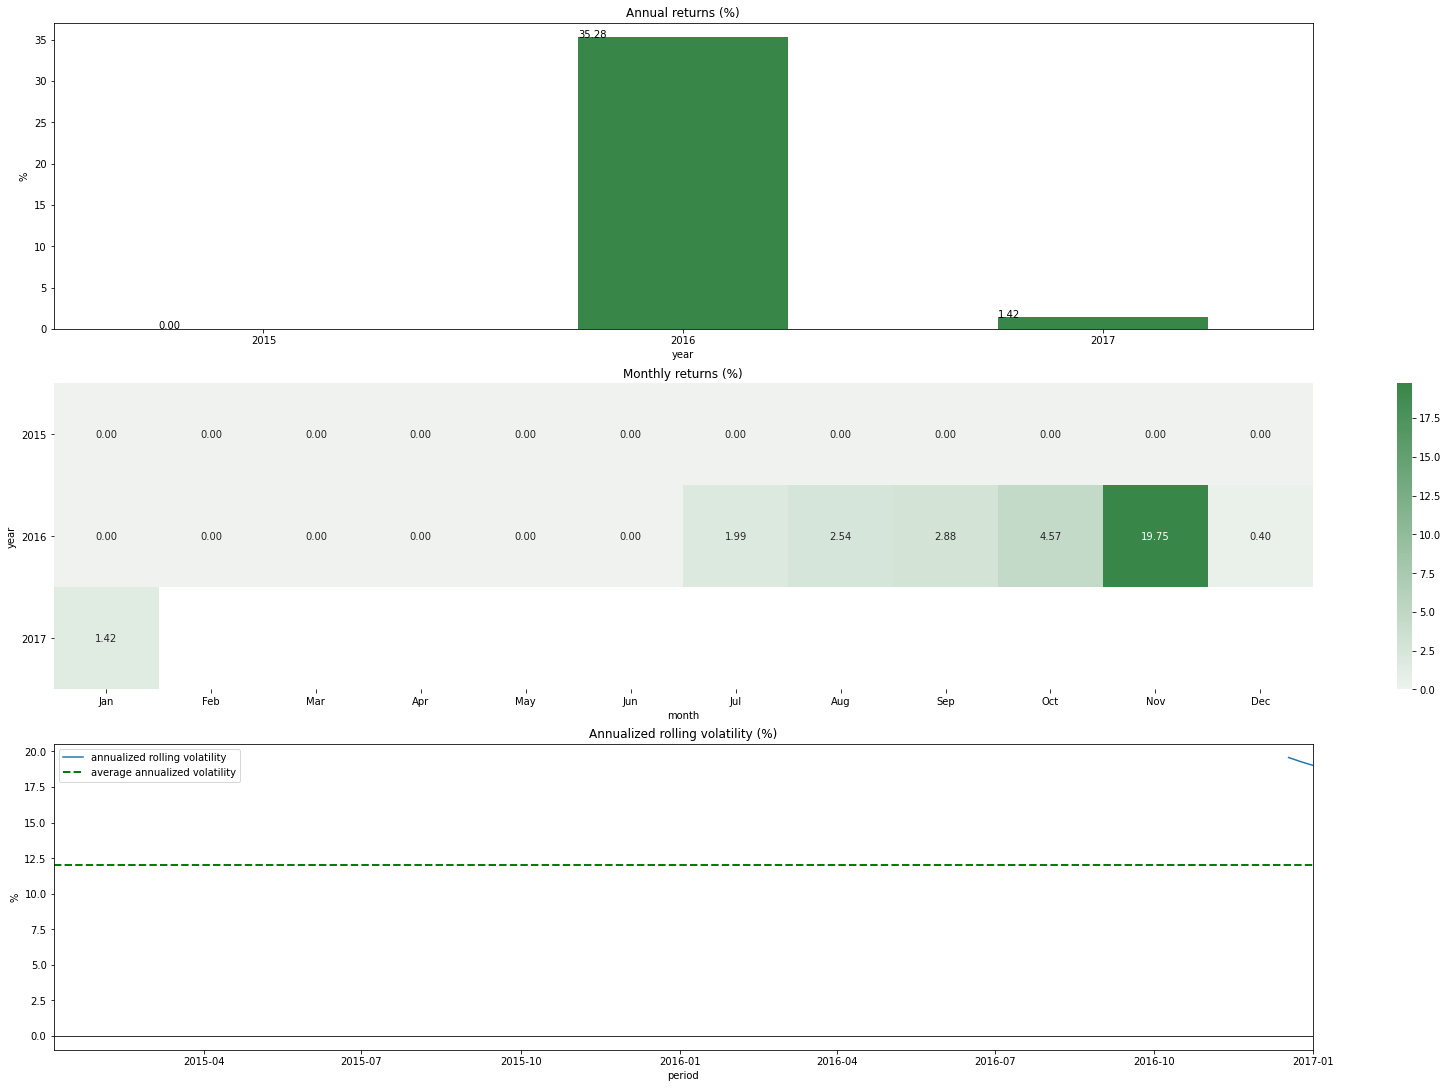

In [18]:
plotter.plot_rets_and_vol(
    selected,
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

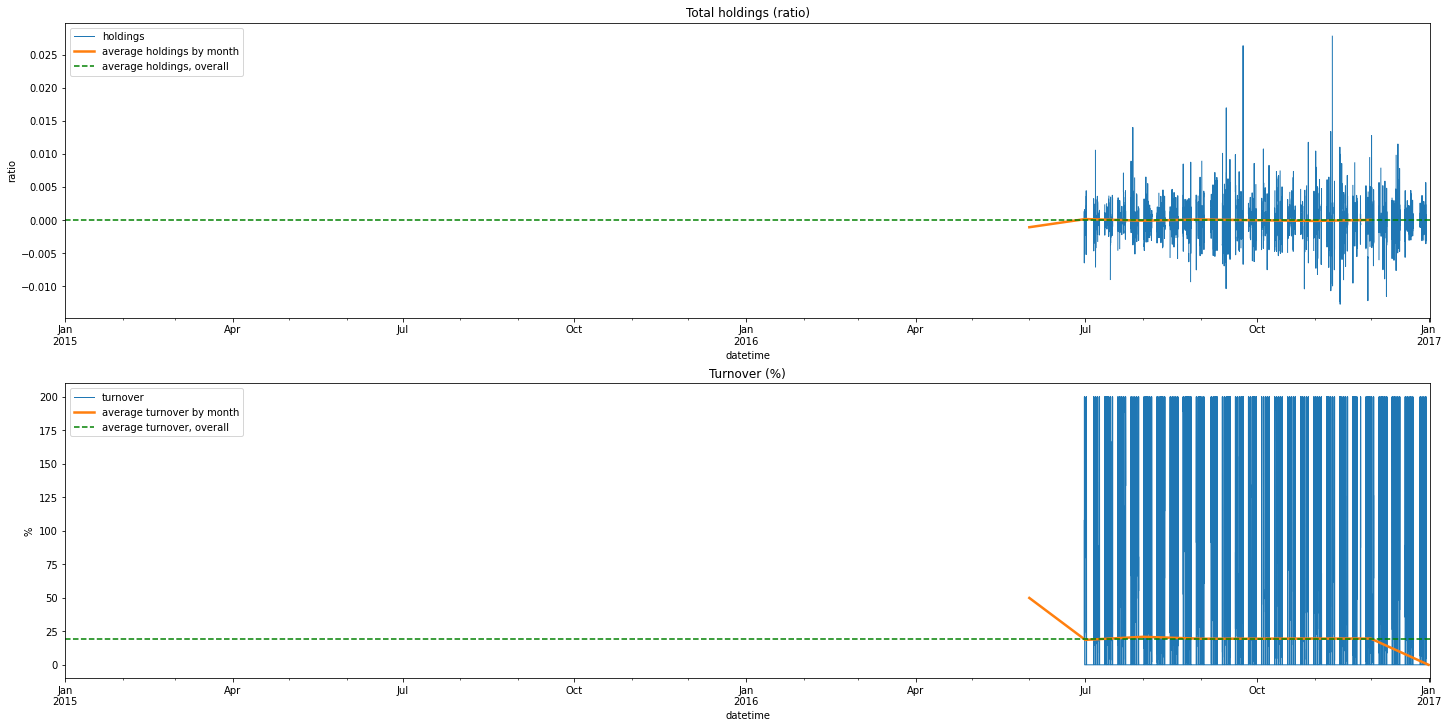

In [19]:
plotter.plot_positions(
    keys=selected,
    mode=eval_config["mode"],
    target_volatility=eval_config["target_volatility"],
)

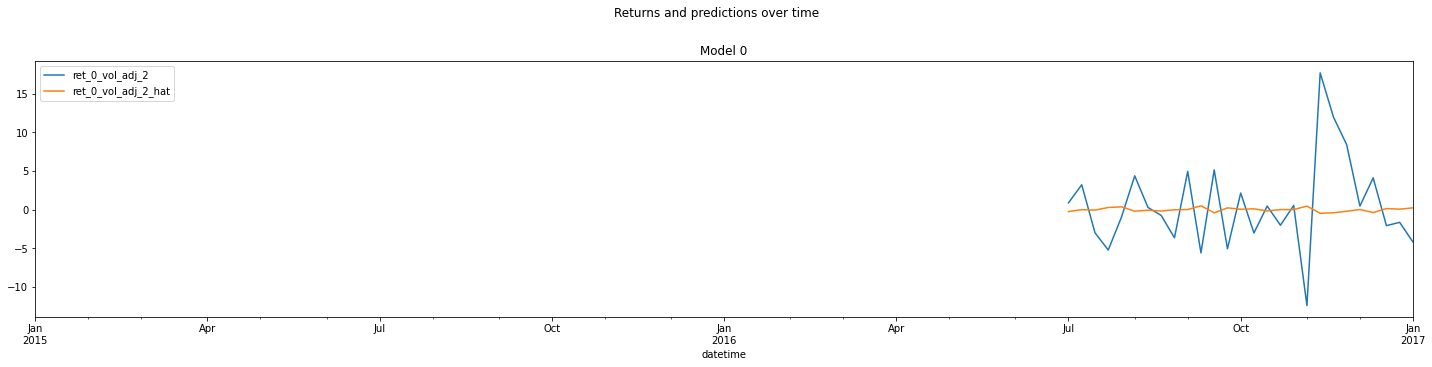

In [20]:
plotter.plot_returns_and_predictions(
    keys=selected[:1],
    resample_rule=eval_config["resample_rule"],
    mode=eval_config["mode"],
)